In this notebook, we begin to work with the data that we scraped from arXiv and then preprocessed in `Scarping and Cleaning the Data.ipynb`. The ultimate goal is to predict the 3-character [MSC (Mathematical Subject Classification)](https://mathscinet.ams.org/mathscinet/msc/msc2020.html) classes for a preprint based on its cleaned title.<a name="cite_ref-a"></a>[<sup>*</sup>](#cite_note-a) This turns out to be a multi-label text classification task. 

More precisely, here, we will:
1) explore and visualize the data;
2) encode the labels; 
3) split into the training and test sets via [stratified sampling for multi-label data](https://link.springer.com/chapter/10.1007/978-3-642-23808-6_10);
4) vectrozie the text data with [TF-IDF (Term Frequency-Inverse Document Frequency)](https://en.wikipedia.org/wiki/Tf%E2%80%93idf);
5) train some basic classifiers. 

<a name="cite_note-a"></a>[*](#cite_ref-a) Our data has other attributes as well, such as primary arXiv category, authors' names etc.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import json

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import hamming_loss


#stratified.py is imported (from the same folder) for multi-label stratified sampling. 
#The short python code is based on the iterstrat library.
from stratified import multilabel_train_test_split


from scipy import sparse

We first load the data. Among the columns, we only keep `primary_category`, `cleaned_title` and `MSC`.

In [2]:
data=pd.read_csv('./data/data.csv',index_col=False)
data=data[['primary_category','cleaned_title','MSC']]

#While loading, the lists under the MSC column are loaded as strings. They should be turned back into lists.
data['MSC']=data['MSC'].apply(lambda x:eval(x))
data.head()

,primary_category,cleaned_title,MSC
0,math.NA,quasi monoton robust local continu piecewis po...,"[65N, 41A]"
1,math.AT,higher structur ration homotopi theori,"[55S, 16S, 18M, 18G, 55R, 55P, 55Q]"
2,math.QA,indecompos involut solut yang baxt equat finit...,"[81R, 16T, 20E, 20N]"
3,math.QA,kashiwara vergn solut degre degre,"[57K, 17B]"
4,math.QA,tetrahedron equat quantum cluster algebra,"[81R, 82B, 13F]"


Starting data visualization: which primary categories have been most prevalent? 

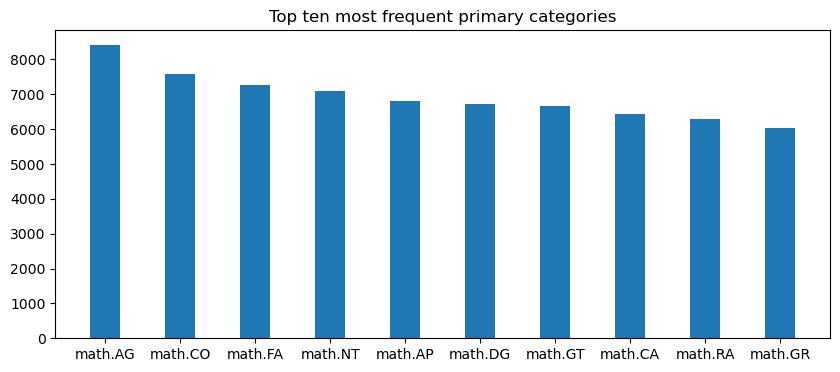

In [3]:
fig=plt.figure(figsize=(10,4))
ax=fig.add_subplot(1,1,1)

#Top 10 most frequent primary categories (bar chart)
ax.bar(x=data['primary_category'].value_counts().head(10).index, 
        height=data['primary_category'].value_counts().head(10),width=0.4)
ax.set_title('Top ten most frequent primary categories')

plt.show()

The labels (MSC classes) should be encoded. As we go over the data frame to do so, we also form a dictionary of different words constituting the titles along with their multiplicities. 

In [4]:
#To record the number of occurances of each class. 
dict_MSC={}
num_labels=[]
total_num_labels=0

#To recored the number of occurences of each word.
dict_words={}

for row in range(data.shape[0]):
    classes=data['MSC'][row]
    temp=len(classes)
    num_labels+=[temp]
    total_num_labels+=temp
    for MSC in classes:
        if MSC in dict_MSC.keys():
            dict_MSC[MSC]+=1
        else:
            dict_MSC[MSC]=1

print(f'The number of different labels is {len(dict_MSC)}.\n')
print(f'The average number of labels per entry is {round(total_num_labels/data.shape[0],2)}.')


data=pd.concat((data,pd.DataFrame(data=0,index=np.arange(data.shape[0]),
                             columns=list(dict_MSC.keys()))),
                            axis=1)

for row in range(data.shape[0]):
    
    words=data['cleaned_title'][row].split(' ')      #The titles are cleaned, no consecutive spaces.
    for word in words: 
        if word in dict_words.keys():
            dict_words[word]+=1
        else:
            dict_words[word]=1
                
    classes=data['MSC'][row]
    for MSC in classes:
        data.at[row,MSC]=1

data.drop(columns=['MSC'],inplace=True)

data.head()

The number of different labels is 532.

The average number of labels per entry is 2.37.


,primary_category,cleaned_title,65N,41A,55S,16S,18M,18G,55R,55P,...,54J,62Q,76Y,76V,74L,76X,76Q,51L,76H,76K
0,math.NA,quasi monoton robust local continu piecewis po...,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,math.AT,higher structur ration homotopi theori,0,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,math.QA,indecompos involut solut yang baxt equat finit...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,math.QA,kashiwara vergn solut degre degre,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,math.QA,tetrahedron equat quantum cluster algebra,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Visualizing the most common labels (MSC classes). 

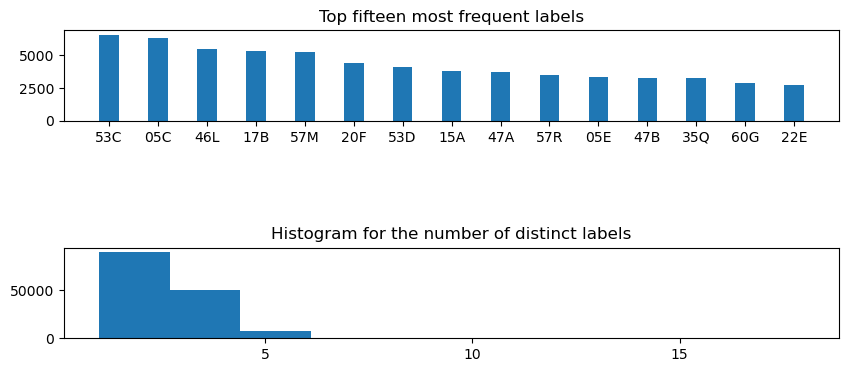

In [5]:
fig=plt.figure(figsize=(10,4))


#Top 10 most frequent MSC classes (bar chart)
ax1=fig.add_subplot(3,1,1)
top_index=np.argsort(-np.asarray(list(dict_MSC.values())))[0:15]
ax1.bar(x=np.asarray(list(dict_MSC.keys()))[top_index],
        height=np.asarray(list(dict_MSC.values()))[top_index],width=0.4)
ax1.set_title('Top fifteen most frequent labels')

#Number of labels (histogram)
ax2=fig.add_subplot(3,1,3)
ax2.hist(num_labels)
ax2.locator_params(axis='x', integer=True)
ax2.set_title('Histogram for the number of distinct labels')

plt.show()

There may be labels that occur only once throughout the data. Then one of the training or test datasets will lack that label. To avoind this, we drop such labels along with instances whose only label is such a thing (in necessary).

In [6]:
MSC_only_once=[]
ascending=np.argsort(np.asarray(list(dict_MSC.values())))
for arg in ascending:
    if np.asarray(list(dict_MSC.values()))[arg]==1:
        MSC_only_once+=[np.asarray(list(dict_MSC.keys()))[arg]]
    else:
        break

print('MSC classes that happen only once are:', *MSC_only_once)

data.drop(columns=MSC_only_once,inplace=True)

if data[(data.iloc[:,2:]==0).all(axis=1)].shape[0]==0:
    print('\nNo need to drop any rows.')
else: 
    drop_index=data[(data.iloc[:,2:]==0).all(axis=1)].index
    data.drop(columns=MSC_only_once,inplace=True)
    print(f'\nThe number of rows dropped is {drop_index.shape[0]}')


#Saving the encoded data in a compressed form.     
data.to_csv('./data/data_encoded.csv',compression='zip',index=False)

MSC classes that happen only once are: 76K 83B

No need to drop any rows.


We next look at the cleaned titles (to be used as the input text data). How many words appear in them? Which words have been most common?

The total number of words appearing in cleaned titles is 26222.

The average number of words per cleaned title is 6.48.


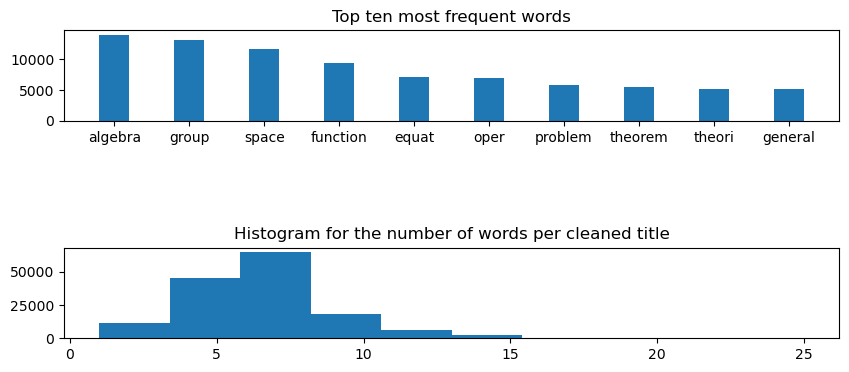

In [7]:
print(f'The total number of words appearing in cleaned titles is {len(dict_words)}.\n')

num_words=data['cleaned_title'].apply(lambda x:len(x.split(' ')))

print(f'The average number of words per cleaned title is {round(num_words.mean(),2)}.')

fig=plt.figure(figsize=(10,4))
ax1=fig.add_subplot(3,1,1)

#Top 10 most frequent primary categories (bar chart)
top_index=np.argsort(-np.asarray(list(dict_words.values())))[0:10]
ax1.bar(x=np.asarray(list(dict_words.keys()))[top_index],
        height=np.asarray(list(dict_words.values()))[top_index],width=0.4)
ax1.set_title('Top ten most frequent words')


ax2=fig.add_subplot(3,1,3)

#Number of constituent words (histogram)
ax2.hist(num_words)
ax2.locator_params(axis='x', integer=True)
ax2.set_title('Histogram for the number of words per cleaned title')

plt.show()

Stratified splitting of the data into training and test sets based on the [iterative-stratification](https://github.com/trent-b/iterative-stratification) library. We save the corresponding row indices for future use. 

In [8]:
X_train, X_test, y_train, y_test = multilabel_train_test_split(data['cleaned_title'],
                                                               data.iloc[:,2:],stratify=data.iloc[:,2:], 
                                                               test_size=0.3, random_state=1)

train_index=np.asarray(X_train.index).tolist()
print(f'The number of training instances: {len(train_index)}')
with open('./data/train_index.json','w') as file:
    json.dump(train_index,file)

test_index=np.asarray(X_test.index).tolist()
print(f'The number of test instances: {len(test_index)}')
with open('./data/test_index.json','w') as file:
    json.dump(test_index,file)

The number of training instances: 104129
The number of test instances: 44735


Are different labels (MSC classes) distributed proportionally between the training and test sets? Bar charts for the relative frequency of top MSC classes.

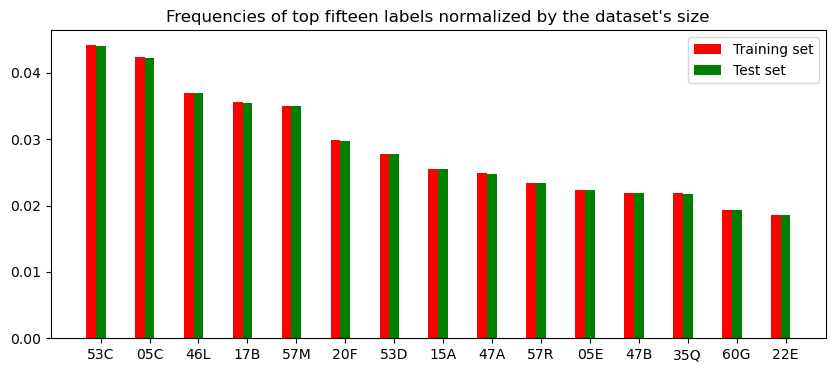

In [9]:
top_index=np.argsort(-np.asarray(list(dict_MSC.values())))[0:15]
top_MSC=np.asarray(list(dict_MSC.keys()))[top_index]


ind=np.arange(15)
width=0.2

fig=plt.figure(figsize=(10,4))
ax=fig.add_subplot(111)
ax.bar(x=ind, height=y_train[top_MSC].sum(axis=0)/y_train.shape[0], width=width, color='r')
ax.bar(x=ind+width, height=y_test[top_MSC].sum(axis=0)/y_test.shape[0], width=width, color='g')
ax.set_xticks(ind+width)
ax.set_xticklabels(top_MSC)

ax.set_title("Frequencies of top fifteen labels normalized by the dataset's size")
ax.legend(('Training set','Test set'))

plt.show()

There have been machine learning projects, such as the [arXiv Classifier](https://github.com/arXiv/arxiv-classifier/), aimed at predicting a preprint's primary arXiv category. But our goal is to predict MSC classes which are intuitively finer (multiple MSC classes exist for each math subject). Before proceeding with predicting MSC classes based on preprints' title, we show that, with reasonable accuracy, the primary category can be predicted based on MSC classes with a simple multi-class classifier. 

In [10]:
X_train_CatPred=sparse.csr_matrix(data.iloc[train_index,3:])
y_train_CatPred=data.iloc[train_index,:]['primary_category']

X_test_CatPred=sparse.csr_matrix(data.iloc[test_index,3:])
y_test_CatPred=data.iloc[test_index,:]['primary_category']


clf_CatPred=OneVsRestClassifier(RandomForestClassifier(n_estimators=20,random_state=999),n_jobs=-1)
clf_CatPred.fit(X_train_CatPred,y_train_CatPred)

y_pred_train=clf_CatPred.predict(X_train_CatPred)
y_pred=clf_CatPred.predict(X_test_CatPred)

print('Metrics for predicting the primary arXiv category based on MSC classes:\n')
print(f' Train Accuracy: {round(100*accuracy_score(y_train_CatPred, y_pred_train, normalize=True),2)}%')
print(f" Train F1-score macro: {round(100*f1_score(y_train_CatPred, y_pred_train, average='macro'),2)}%")
print(f" Train F1-score micro: {round(100*f1_score(y_train_CatPred, y_pred_train, average='micro'),2)}%")
print(f" Train F1-score weighted: {round(100*f1_score(y_train_CatPred, y_pred_train, average='weighted'),2)}%")



print(f' \n Test Accuracy:  {round(100*accuracy_score(y_test_CatPred, y_pred, normalize=True),2)}%')
print(f" Test F1-score macro: {round(100*f1_score(y_test_CatPred, y_pred, average='macro'),2)}%")
print(f" Test F1-score micro: {round(100*f1_score(y_test_CatPred, y_pred, average='micro'),2)}%")
print(f" Test F1-score weighted: {round(100*f1_score(y_test_CatPred, y_pred, average='weighted'),2)}%")

Metrics for predicting the primary arXiv category based on MSC classes:

 Train Accuracy: 82.43%
 Train F1-score macro: 66.46%
 Train F1-score micro: 82.43%
 Train F1-score weighted: 82.17%
 
 Test Accuracy:  66.76%
 Test F1-score macro: 22.62%
 Test F1-score micro: 66.76%
 Test F1-score weighted: 65.92%


Next, we disregard the column `primary_category` and proceed with training a model for predicting MSC classes based on the text data under the column `cleaned_title`. First, the text data will be vectorized. 

In [11]:
vectorizer = TfidfVectorizer(ngram_range=(1,2))
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

y_train=sparse.csr_matrix(y_train)
y_test=sparse.csr_matrix(y_test)

print(f'The shapes of X_train and X_test (after encoding): {X_train.shape} and  {X_test.shape}\n')
print(f'The shapes of y_train and y_test: {y_train.shape} and  {y_test.shape}')

The shapes of X_train and X_test (after encoding): (104129, 285754) and  (44735, 285754)

The shapes of y_train and y_test: (104129, 530) and  (44735, 530)


Start with linear SVM classifier. 

In [12]:
clf= OneVsRestClassifier(LinearSVC(random_state=123),n_jobs=-1)

clf.fit(X_train, y_train)


y_pred_train=clf.predict(X_train)
y_pred=clf.predict(X_test)


print('Metrics for predicting the primary arXiv category based on MSC classes:\n')
print(f' Train Accuracy: {round(100*accuracy_score(y_train, y_pred_train, normalize=True),2)}%')
print(f" Train F1-score macro: {round(100*f1_score(y_train, y_pred_train, average='macro'),2)}%")
print(f" Train F1-score micro: {round(100*f1_score(y_train, y_pred_train, average='micro'),2)}%")
print(f" Train F1-score weighted: {round(100*f1_score(y_train, y_pred_train, average='weighted'),2)}%")
print(f' Train Hamming loss: {hamming_loss(y_train, y_pred_train)}')



print(f' \n Test Accuracy:  {round(100*accuracy_score(y_test, y_pred, normalize=True),2)}%')
print(f" Test F1-score macro: {round(100*f1_score(y_test, y_pred, average='macro'),2)}%")
print(f" Test F1-score micro: {round(100*f1_score(y_test, y_pred, average='micro'),2)}%")
print(f" Test F1-score weighted: {round(100*f1_score(y_test, y_pred, average='weighted'),2)}%") 
print(f' Test Hamming loss: {hamming_loss(y_test, y_pred)}') 

Metrics for predicting the primary arXiv category based on MSC classes:

 Train Accuracy: 91.39%
 Train F1-score macro: 97.65%
 Train F1-score micro: 97.4%
 Train F1-score weighted: 97.39%
 Train Hamming loss: 0.00022713118724107997
 
 Test Accuracy:  14.19%
 Test F1-score macro: 21.83%
 Test F1-score micro: 38.23%
 Test F1-score weighted: 36.17%
 Test Hamming loss: 0.003818630045698885


We observe overfit. Let's use cross-validation to remedy this. 

In [13]:
cvmodel=cross_validate(estimator=clf,X=X_train,y=y_train,cv=10,
              return_estimator=True,scoring='accuracy')
best_score_index=np.argsort(-cvmodel['test_score'])[0]
clf_cv=cvmodel['estimator'][best_score_index]

y_pred_train=clf_cv.predict(X_train)
y_pred=clf_cv.predict(X_test)

print('Metrics for predicting the primary arXiv category based on MSC classes:\n')
print(f' Train Accuracy: {round(100*accuracy_score(y_train, y_pred_train, normalize=True),2)}%')
print(f" Train F1-score macro: {round(100*f1_score(y_train, y_pred_train, average='macro'),2)}%")
print(f" Train F1-score micro: {round(100*f1_score(y_train, y_pred_train, average='micro'),2)}%")
print(f" Train F1-score weighted: {round(100*f1_score(y_train, y_pred_train, average='weighted'),2)}%")
print(f' Train Hamming loss: {hamming_loss(y_train, y_pred_train)}')



print(f' \n Test Accuracy:  {round(100*accuracy_score(y_test, y_pred, normalize=True),2)}%')
print(f" Test F1-score macro: {round(100*f1_score(y_test, y_pred, average='macro'),2)}%")
print(f" Test F1-score micro: {round(100*f1_score(y_test, y_pred, average='micro'),2)}%")
print(f" Test F1-score weighted: {round(100*f1_score(y_test, y_pred, average='weighted'),2)}%") 
print(f' Test Hamming loss: {hamming_loss(y_test, y_pred)}') 

Metrics for predicting the primary arXiv category based on MSC classes:

 Train Accuracy: 84.18%
 Train F1-score macro: 93.02%
 Train F1-score micro: 93.26%
 Train F1-score weighted: 93.15%
 Train Hamming loss: 0.0005698302015442747
 
 Test Accuracy:  13.68%
 Test F1-score macro: 21.07%
 Test F1-score micro: 37.25%
 Test F1-score weighted: 35.17%
 Test Hamming loss: 0.0038430084080043696


How has the model performed in terms of the number of labels?

In [14]:
#Turning sparse matrices into np.matrix
y_1=y_test.todense()
y_2=y_pred.todense()

detection_vector=(y_1==y_2).all(axis=1).astype(float)
n_labels=1
list_n_labels=[]
list_accuracy=[]
while True:
    label_number_indicator=(y_1.sum(axis=1)==n_labels).astype(float)
    if label_number_indicator.sum()==0:
        break
    list_n_labels+=[n_labels]
    n_instances=label_number_indicator.sum()
    accuracy=np.dot(np.transpose(detection_vector),label_number_indicator)/n_instances  #np.matrix of size 1*1
    accuracy=accuracy.sum()                                                             #accessing its unique entry
    list_accuracy+=[round(100*accuracy,2)]
    n_labels+=1
    
list_accuracy

[35.2, 8.97, 2.21, 1.04, 0.35, 0.7, 0.97, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

https://towardsdatascience.com/multi-label-classification-using-bag-of-words-bow-and-tf-idf-4f95858740e5 (BoW and Tf-idf with sparse vectors, toxic comments dataset)

https://medium.com/analytics-vidhya/an-introduction-to-multi-label-text-classification-b1bcb7c7364c (Discusses Classifier Chain, uses the Kaggle research topics dataset)

https://towardsdatascience.com/journey-to-the-center-of-multi-label-classification-384c40229bff (Various techniques, OnevsRest, Binary Relevance etc, toxic comment dataset)

**************************************************************

NLP Zero to Hero (IMDB sentiment analysis)

https://medium.com/@prateekgaurav/nlp-zero-to-hero-part-1-introduction-bow-tf-idf-word2vec-c1b11ed77a2
https://medium.com/@prateekgaurav/nlp-zero-to-hero-part-2-vanilla-rnn-lstm-gru-bi-directional-lstm-77fd60fc0b44
https://medium.com/@prateekgaurav/nlp-zero-to-hero-part-3-transformer-based-models-conclusion-8191186301a9


*****************************************************************

Much more relevant, problems with many labels

https://www.kdnuggets.com/2023/03/multilabel-nlp-analysis-class-imbalance-loss-function-approaches.html

https://keras.io/examples/nlp/multi_label_classification/

(Hugging Face: https://discuss.huggingface.co/t/most-efficient-multi-label-classifier/9296)

******************************************************************

Multioutput 
https://www.kdnuggets.com/2023/08/multilabel-classification-introduction-python-scikitlearn.html

Multioutput vs OnevsRest for Multilabel classification
https://stackoverflow.com/questions/42819460/what-is-the-difference-between-onevsrestclassifier-and-multioutputclassifier-in